In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv
/kaggle/input/crime-cast-forecasting-crime-categories/train.csv
/kaggle/input/crime-cast-forecasting-crime-categories/test.csv


In [2]:
class ARGS():
    seed = 42
    n_folds = 5
    train_split = 0.80
    val_split = 0.20

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Code Reproducibility
import random
random.seed(ARGS.seed)
np.random.seed(ARGS.seed)
from scipy.stats import zscore
import folium
from folium.plugins import HeatMap
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,f1_score,recall_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier

In [4]:
# Load the data
df = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv')
test = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv')

In [5]:
print("Training data shape",df.shape)
print("Testing data shape",test.shape)

Training data shape (20000, 22)
Testing data shape (5000, 21)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               20000 non-null  object 
 1   Cross_Street           3448 non-null   object 
 2   Latitude               20000 non-null  float64
 3   Longitude              20000 non-null  float64
 4   Date_Reported          20000 non-null  object 
 5   Date_Occurred          20000 non-null  object 
 6   Time_Occurred          20000 non-null  float64
 7   Area_ID                20000 non-null  float64
 8   Area_Name              20000 non-null  object 
 9   Reporting_District_no  20000 non-null  float64
 10  Part 1-2               20000 non-null  float64
 11  Modus_Operandi         17259 non-null  object 
 12  Victim_Age             20000 non-null  float64
 13  Victim_Sex             17376 non-null  object 
 14  Victim_Descent         17376 non-null  object 
 15  Pr

In [7]:
# Checking for the Null Values from the dataset
print(pd.DataFrame({'Column': df.columns, 'Missing Values': df.isnull().sum().values}))

                   Column  Missing Values
0                Location               0
1            Cross_Street           16552
2                Latitude               0
3               Longitude               0
4           Date_Reported               0
5           Date_Occurred               0
6           Time_Occurred               0
7                 Area_ID               0
8               Area_Name               0
9   Reporting_District_no               0
10               Part 1-2               0
11         Modus_Operandi            2741
12             Victim_Age               0
13             Victim_Sex            2624
14         Victim_Descent            2624
15           Premise_Code               0
16    Premise_Description               5
17       Weapon_Used_Code           12665
18     Weapon_Description           12665
19                 Status               0
20     Status_Description               0
21         Crime_Category               0


In [8]:
df.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


In [9]:
df.describe(include='all')

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
count,20000,3448,20000.000000,20000.000000,20000,20000,20000.000000,20000.000000,20000,20000.000000,...,20000.000000,17376,17376,20000.000000,19995,7335.000000,7335,20000,20000,20000
unique,12399,1495,NaN,NaN,811,366,NaN,NaN,21,NaN,...,NaN,4,17,NaN,216,NaN,57,5,5,6
top,6TH,BROADWAY,NaN,NaN,07/13/2020 12:00:00 AM,01/01/2020 12:00:00 AM,NaN,NaN,77th Street,NaN,...,NaN,M,H,NaN,STREET,NaN,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
freq,33,56,NaN,NaN,87,137,NaN,NaN,1345,NaN,...,NaN,8538,6143,NaN,5033,NaN,3990,15236,15236,11666
mean,NaN,NaN,33.940704,-117.893072,NaN,NaN,1352.380350,10.834250,NaN,1129.599200,...,30.135000,NaN,NaN,297.176950,NaN,366.405044,NaN,NaN,NaN,NaN
std,NaN,NaN,2.126810,7.377726,NaN,NaN,646.100291,6.033166,NaN,603.330519,...,21.863645,NaN,NaN,212.007298,NaN,120.485687,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000,-118.663400,NaN,NaN,1.000000,1.000000,NaN,101.000000,...,-2.000000,NaN,NaN,101.000000,NaN,101.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,34.009200,-118.429700,NaN,NaN,930.000000,6.000000,NaN,632.000000,...,12.000000,NaN,NaN,101.000000,NaN,312.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,34.058700,-118.323000,NaN,NaN,1430.000000,11.000000,NaN,1162.000000,...,31.000000,NaN,NaN,203.000000,NaN,400.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,34.165025,-118.274400,NaN,NaN,1900.000000,16.000000,NaN,1622.000000,...,46.000000,NaN,NaN,501.000000,NaN,400.000000,NaN,NaN,NaN,NaN


In [10]:
# Selecting only numerical features from the dataset
numerical_feats = df.select_dtypes(include=['int64', 'float64'])
print('Skewness in Training Data\n')
display(df[numerical_feats.columns].skew())

Skewness in Training Data



Latitude                -15.852085
Longitude                15.915463
Time_Occurred            -0.474716
Area_ID                  -0.011008
Reporting_District_no    -0.004086
Part 1-2                  0.331902
Victim_Age                0.114913
Premise_Code              0.541494
Weapon_Used_Code         -1.033417
dtype: float64

In [11]:
print('Kurtosis in Training Data\n')
display(df[numerical_feats.columns].kurtosis())

Kurtosis in Training Data



Latitude                 250.037171
Longitude                251.377598
Time_Occurred             -0.716528
Area_ID                   -1.179491
Reporting_District_no     -1.181142
Part 1-2                  -1.890030
Victim_Age                -0.754531
Premise_Code              -1.070649
Weapon_Used_Code           0.126872
dtype: float64

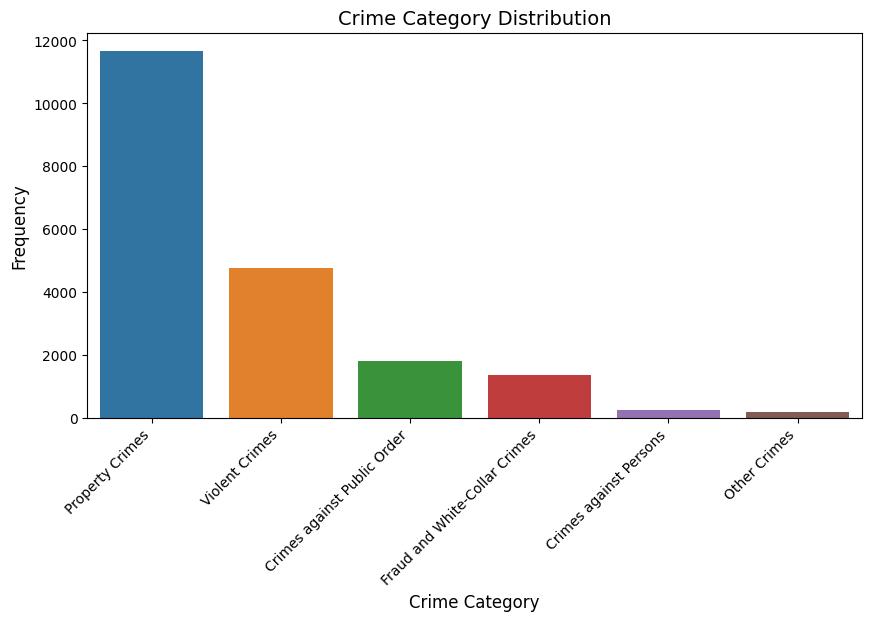

In [12]:
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed

# Create the bar plot with Seaborn
crime_count = df['Crime_Category'].value_counts()
sns.barplot(x=crime_count.index, y=crime_count.values)

# Customize the plot
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.xlabel('Crime Category', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Crime Category Distribution', fontsize=14)

plt.show()

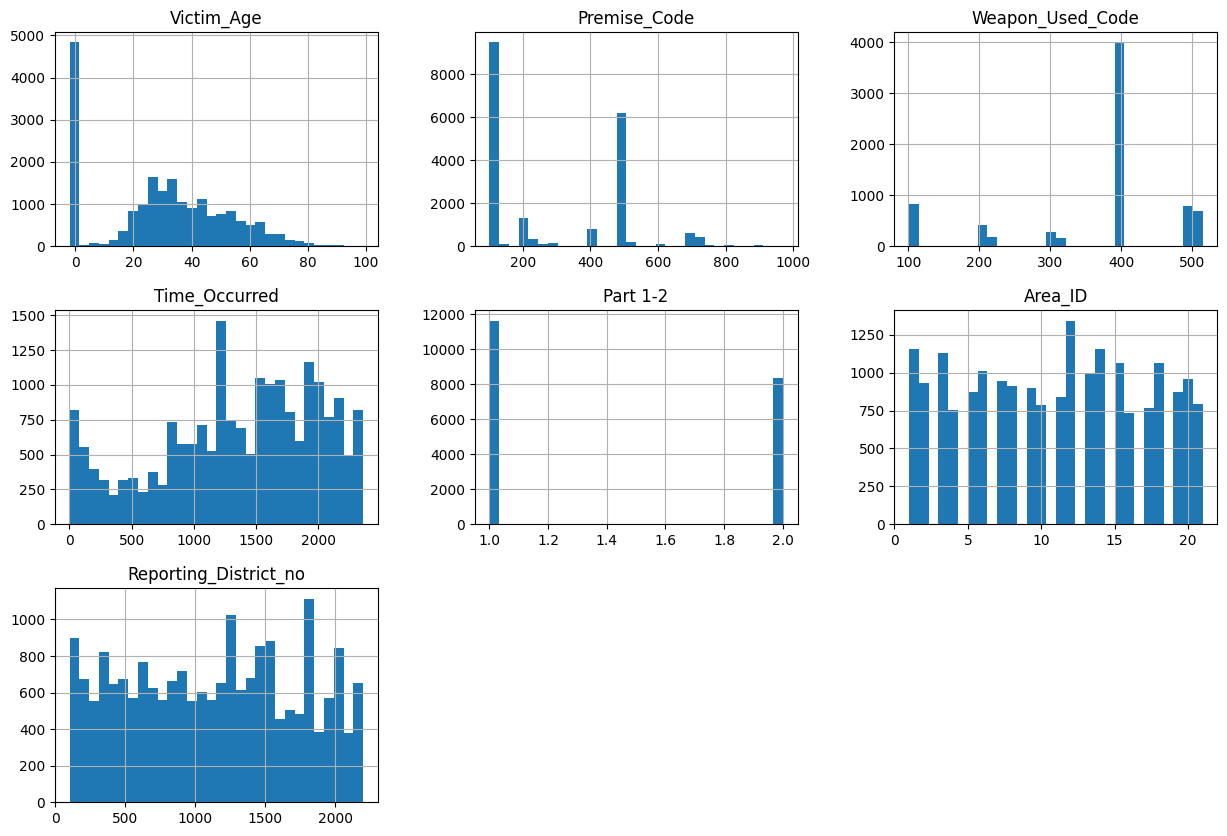

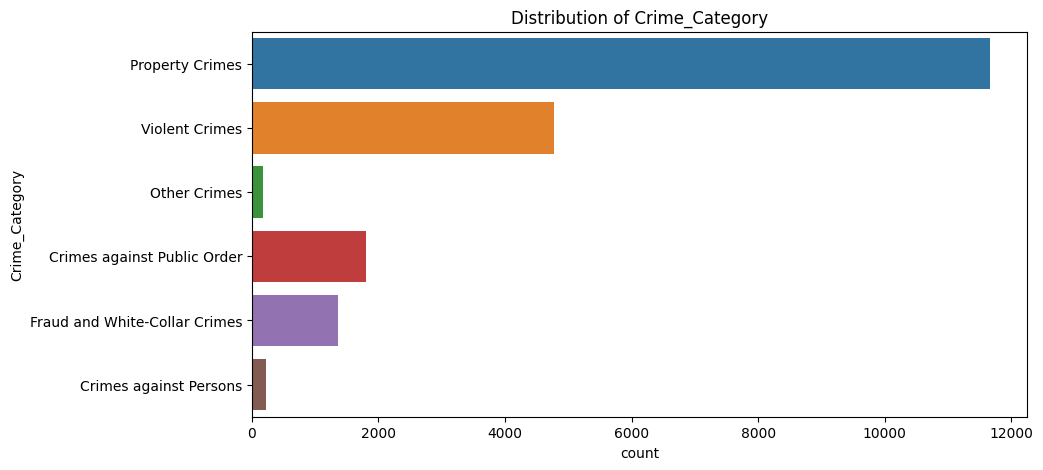

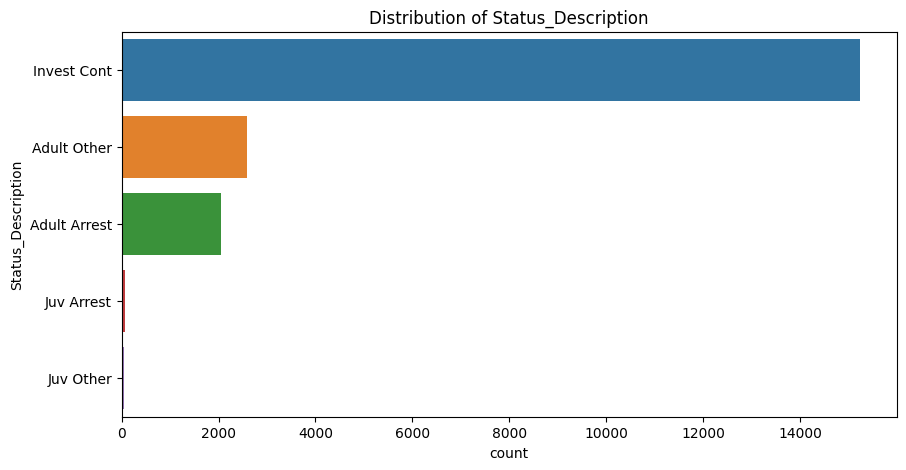

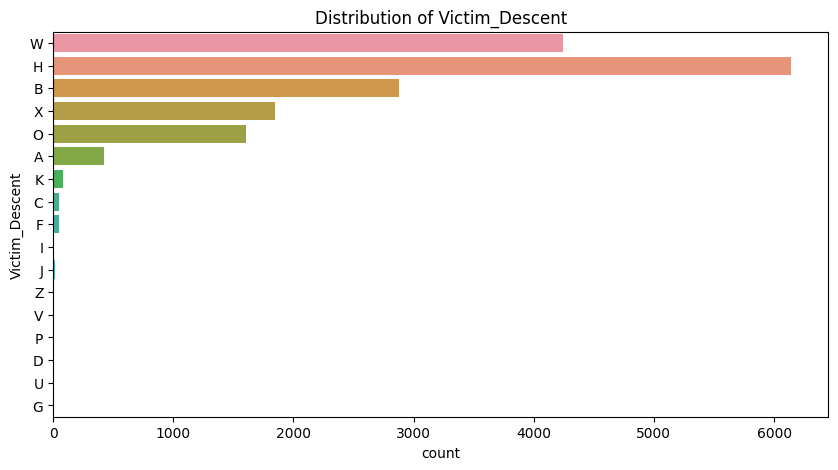

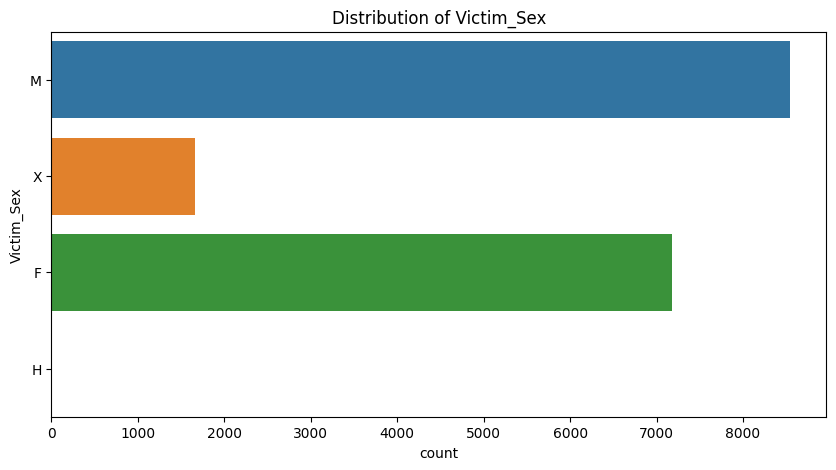

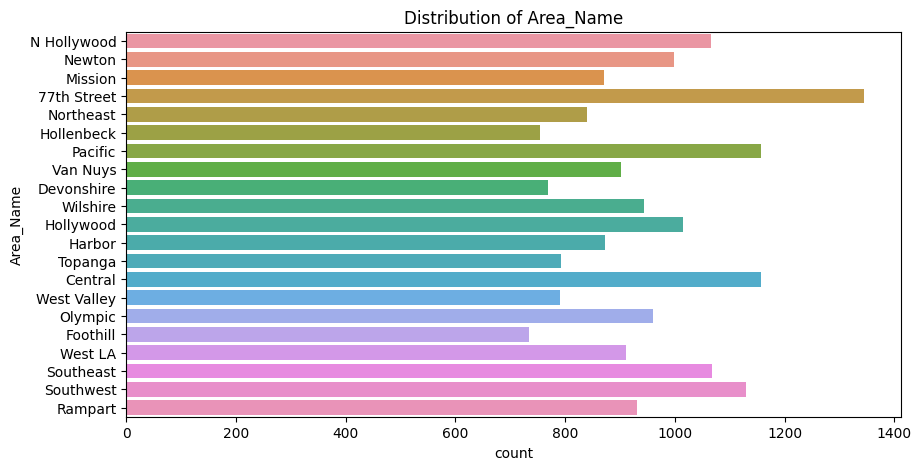

In [13]:
categorical_cols = ['Crime_Category','Status_Description','Victim_Descent','Victim_Sex','Area_Name']
numeric_cols = ['Victim_Age','Premise_Code','Weapon_Used_Code','Time_Occurred','Part 1-2','Area_ID','Reporting_District_no']

# Plot histograms for numerical features
df[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.show()

# Plot bar plots for categorical features
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(y=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.show()

(5084, 22)


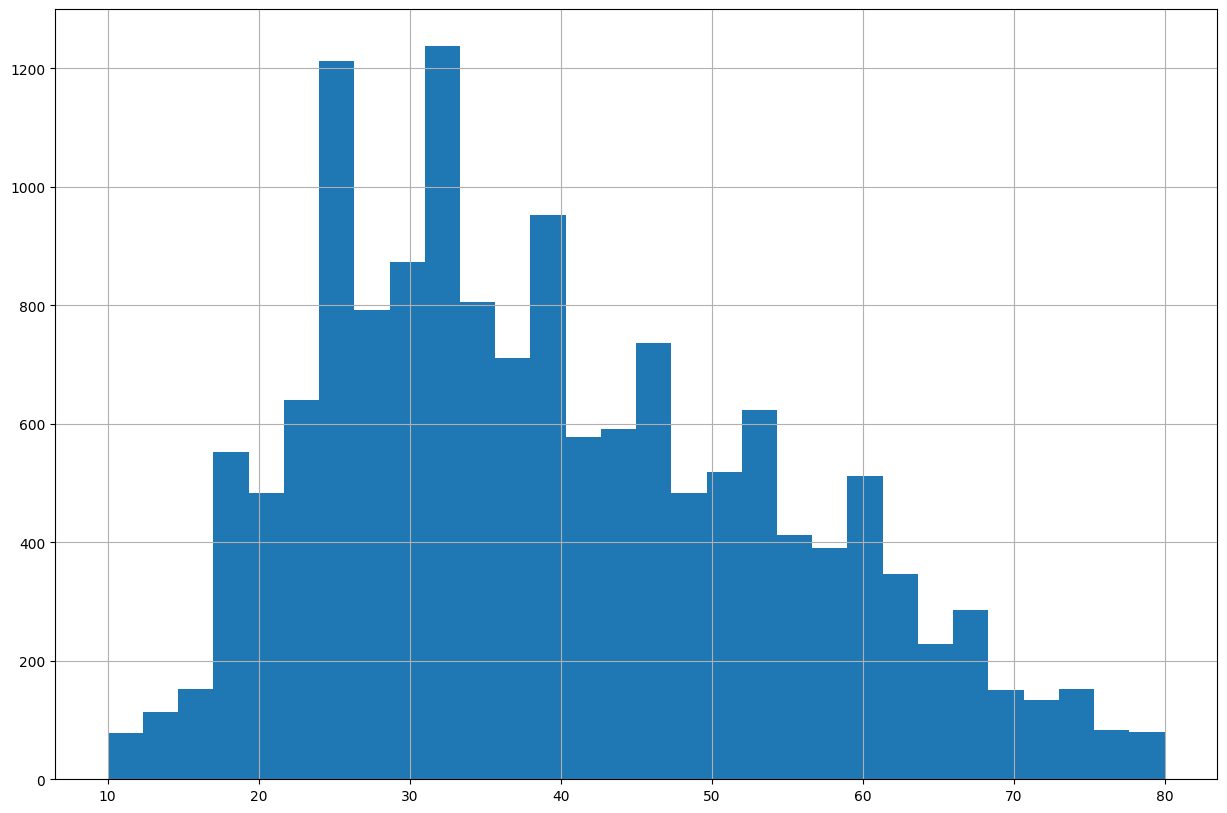

In [14]:
# looks like there is a problem with victim age
print(df[(df['Victim_Age'] > 80) | (df['Victim_Age'] < 10)].shape)

#Fixing the victim age column
# Function to replace invalid values with np.nan
def replace_invalid_age(age):
    if age == 0 or age < 10 or age > 80:
        return np.nan
    else:
        return age

# Apply the function to the 'age' column
df['Victim_Age'] = df['Victim_Age'].apply(replace_invalid_age)

#Plotting it again
# Plot histograms for numerical features
df['Victim_Age'].hist(bins=30, figsize=(15, 10))
plt.show()

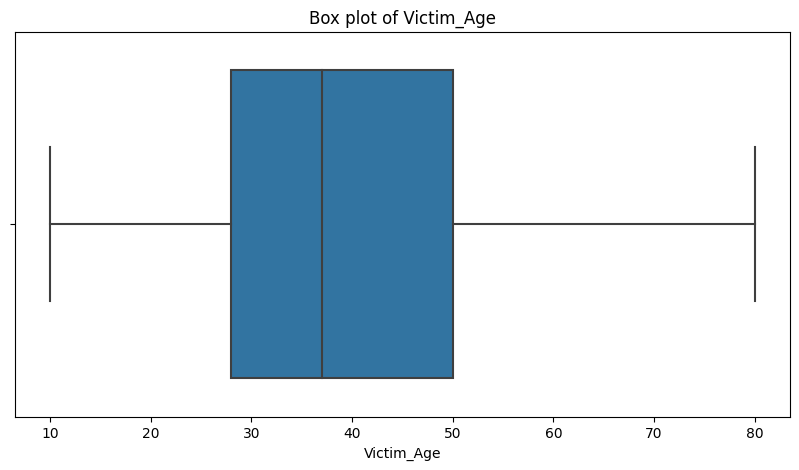

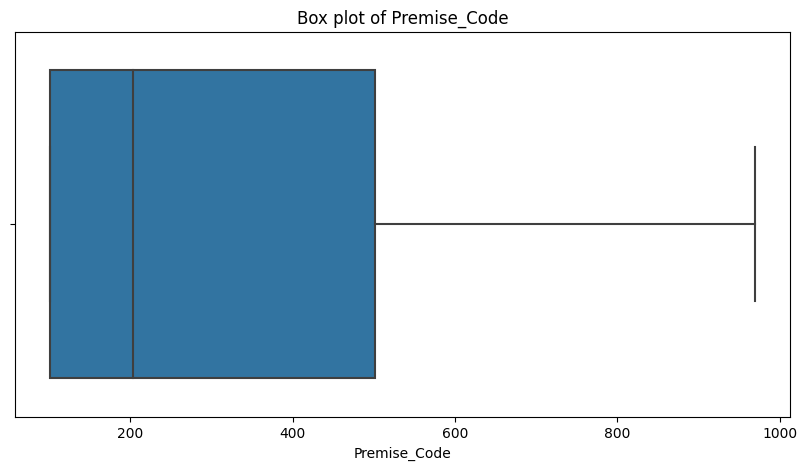

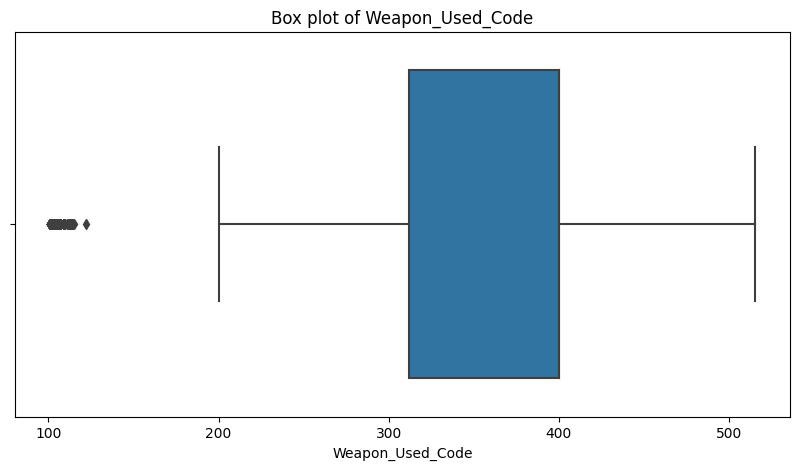

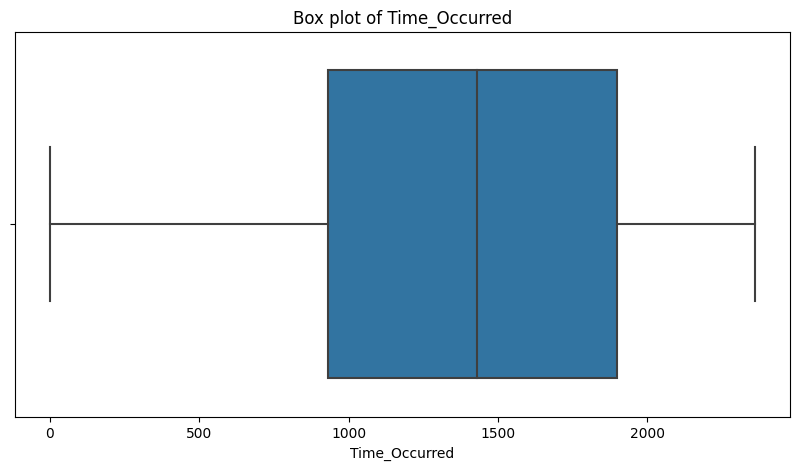

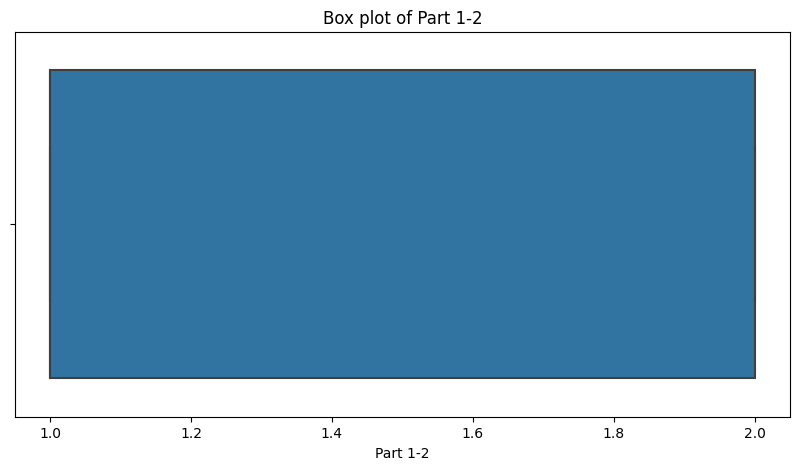

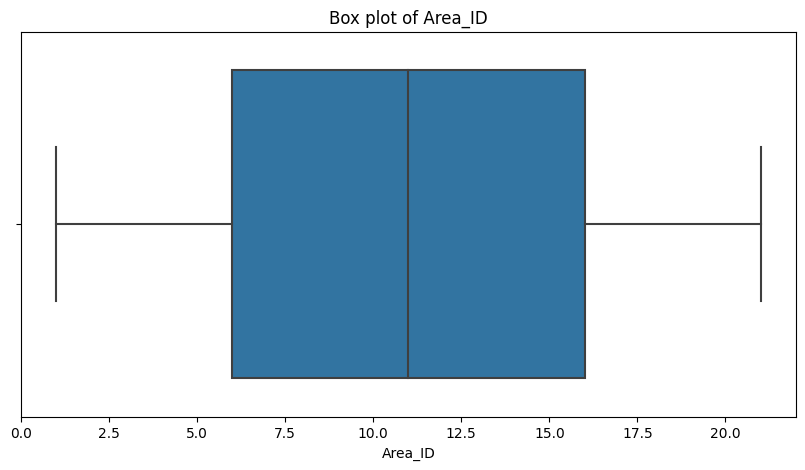

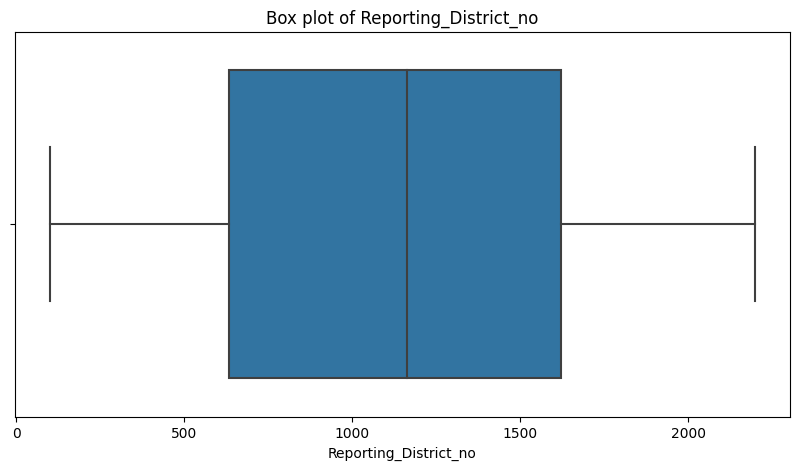

Outliers detected:
 Victim_Age                0
Premise_Code             21
Weapon_Used_Code          0
Time_Occurred             0
Part 1-2                  0
Area_ID                   0
Reporting_District_no     0
dtype: int64


In [15]:
# Box plots for outlier detection
for col in numeric_cols:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df[col])
    plt.title(f'Box plot of {col}')
    plt.show()

# Z-score for outlier detection
z_scores = df[numeric_cols].apply(zscore)
outliers = (z_scores.abs() > 3).sum()
print("Outliers detected:\n", outliers)

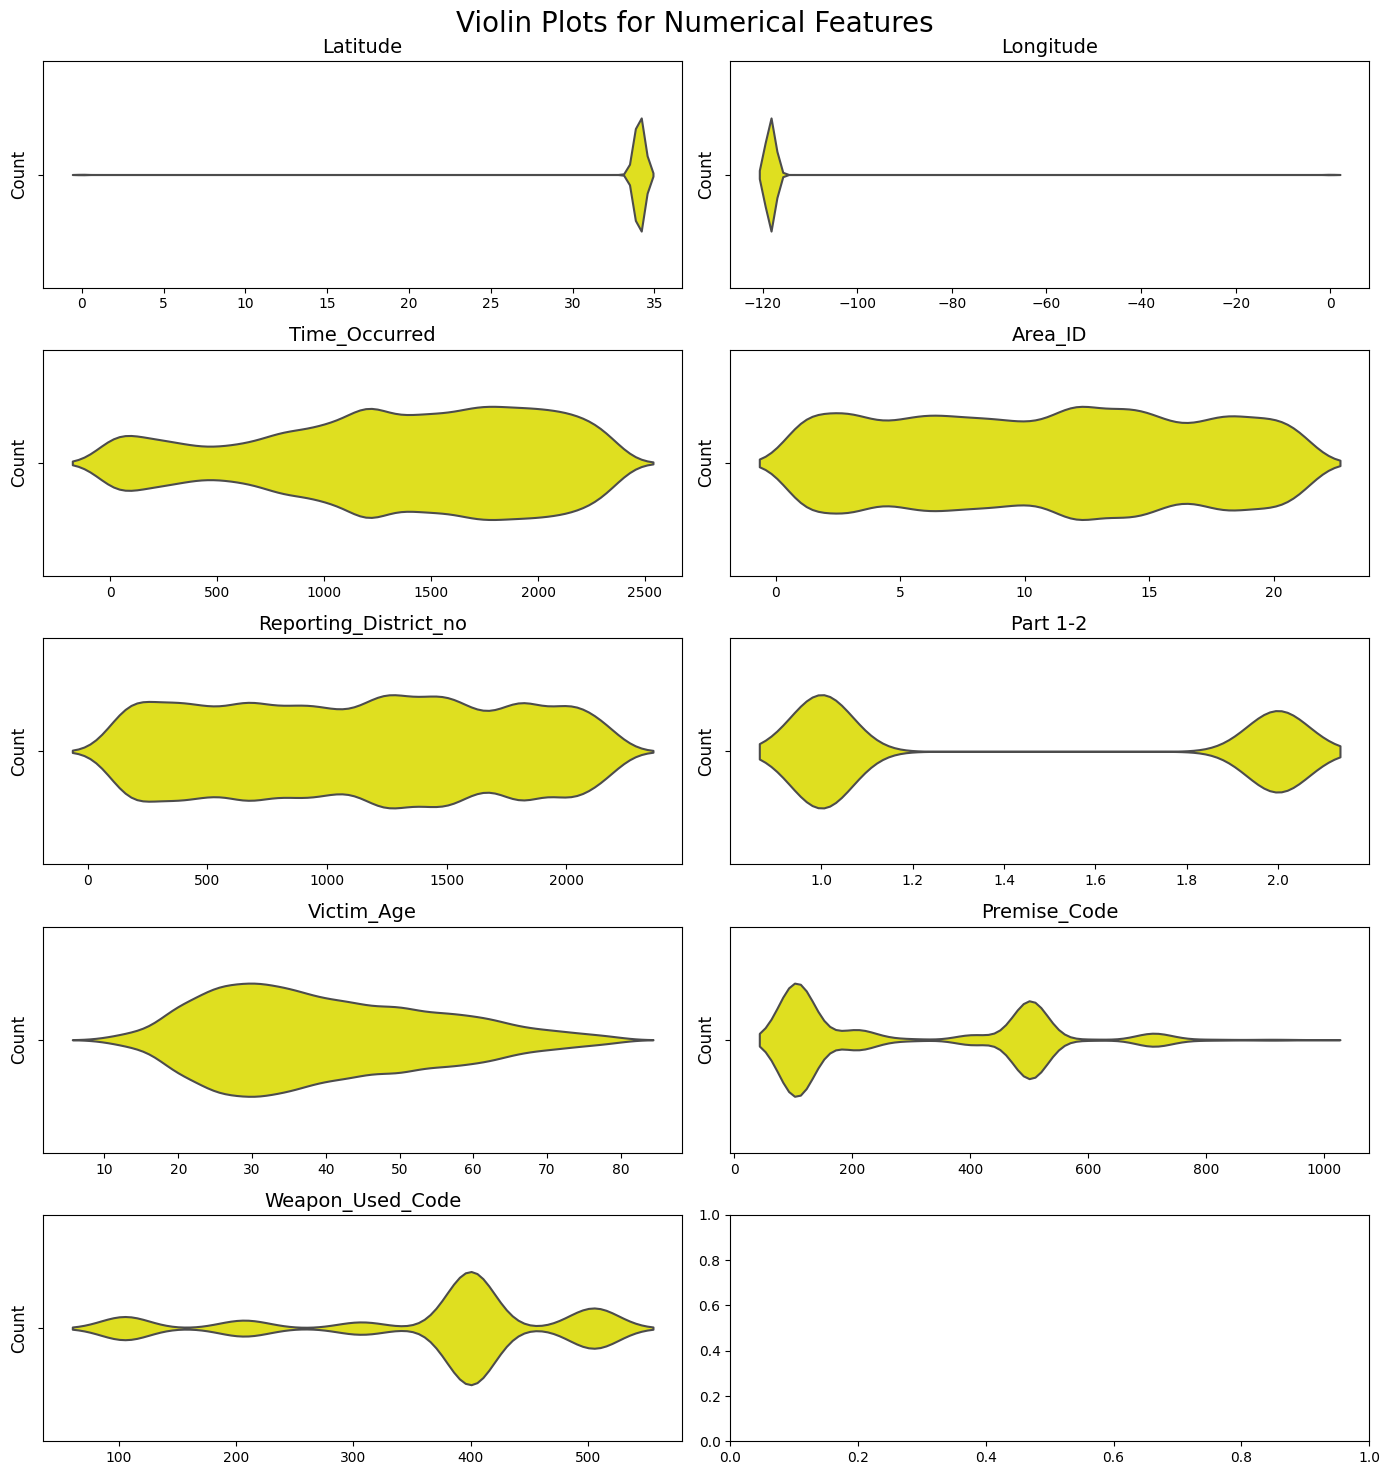

In [16]:
# Plotting the violin plots for numerical features to show the distribution of data

# Set up subplots for box plots
fig, axes = plt.subplots(5, 2, figsize=(14, 15))

# Flatten the axes for easy iteration
axes = axes.ravel()

# Iterate through numeric columns and create box plots
for i, column in enumerate(numerical_feats):
    sns.violinplot(x=column, data=df, color='yellow', width=0.5, inner=None, ax=axes[i])  # Use inner=None to hide outliers
    axes[i].set_title(f'{column}', fontsize=14)
    axes[i].set_xlabel(None)
    axes[i].set_ylabel('Count', fontsize=12)

plt.suptitle('Violin Plots for Numerical Features', fontsize=20)
plt.tight_layout()
plt.show()

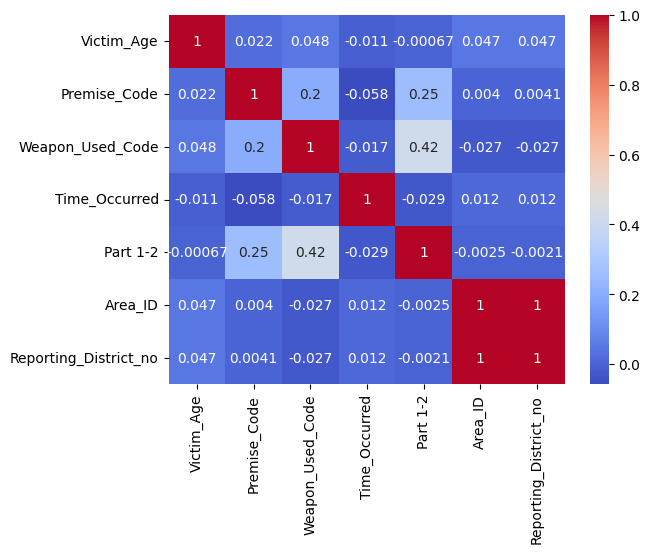

In [17]:
# Correlation matrix
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

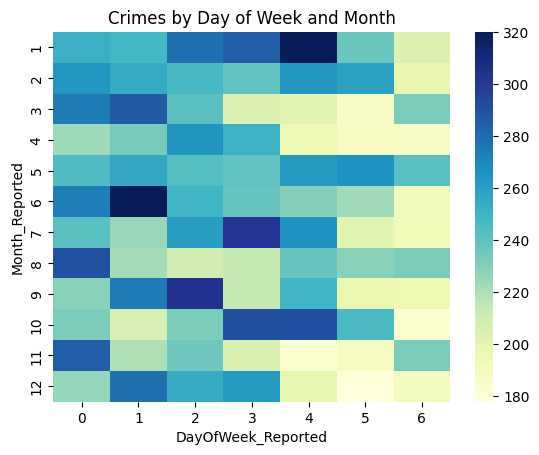

In [18]:
# Extracting date features
# Convert to datetime, specifying the correct format
df['Date_Reported'] = pd.to_datetime(df['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p')

# Extract features
df['Year_Reported'] = df['Date_Reported'].dt.year
df['Month_Reported'] = df['Date_Reported'].dt.month
df['Day_Reported'] = df['Date_Reported'].dt.day
df['DayOfWeek_Reported'] = df['Date_Reported'].dt.dayofweek

df_pivot = df.pivot_table(index='Month_Reported', columns='DayOfWeek_Reported', aggfunc='size', fill_value=0)
sns.heatmap(df_pivot, cmap='YlGnBu')
plt.title('Crimes by Day of Week and Month')
plt.show()

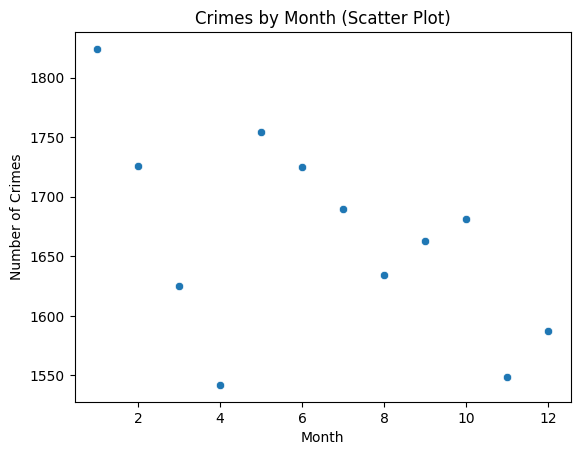

In [19]:
df_agg = df['Month_Reported'].value_counts().reset_index(name='Number_of_Crimes').rename(columns={'index':'Month_Reported'})
sns.scatterplot(x='Month_Reported', y='Number_of_Crimes', data=df_agg)
plt.title('Crimes by Month (Scatter Plot)')
plt.ylabel('Number of Crimes')
plt.xlabel('Month')
plt.show()

In [20]:
# Heatmap of crime occurrences if you have latitude and longitude
m = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=12)
heat_data = [[row['Latitude'], row['Longitude']] for index, row in df.iterrows()]
HeatMap(heat_data).add_to(m)
m.save('crime_heatmap.html')

In [21]:
columns_to_drop = ['Cross_Street', 'Longitude', 'Latitude', 'Status_Description',
                   'Date_Reported', 'Date_Occurred', 'Area_Name']

df = df.drop(columns_to_drop, axis=1)
test = test.drop(columns_to_drop, axis=1)

In [22]:
# Extracting features and target variable
X = df.drop('Crime_Category' ,axis=1)
y = df['Crime_Category']

In [23]:
# Spliting training Data into Model training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2,
                                                 random_state = ARGS.seed, stratify = y)

In [24]:
# Create a dummy classifier
dummy_clf = DummyClassifier(strategy="most_frequent")

# Fit the classifier on the training data
dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict(X_val)
print(classification_report(y_val, dummy_pred))

                               precision    recall  f1-score   support

       Crimes against Persons       0.00      0.00      0.00        45
  Crimes against Public Order       0.00      0.00      0.00       362
Fraud and White-Collar Crimes       0.00      0.00      0.00       271
                 Other Crimes       0.00      0.00      0.00        36
              Property Crimes       0.58      1.00      0.74      2333
               Violent Crimes       0.00      0.00      0.00       953

                     accuracy                           0.58      4000
                    macro avg       0.10      0.17      0.12      4000
                 weighted avg       0.34      0.58      0.43      4000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# Preprocessing the data
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])
categorical_features = X_train.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [26]:
# Model-1: Baseline Logistic Regression

classifier = LogisticRegression(max_iter=1000)
feature_selection = SelectKBest(chi2)
# Pipeline combining preprocessing, feature selection, and classifier
lr1 = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])

lr1.fit(X_train,y_train)

# Make predictions on the validation set
y_pred = lr1.predict(X_val)

# Print classification report (decoded labels)
print(classification_report(y_val, y_pred))

                               precision    recall  f1-score   support

       Crimes against Persons       0.00      0.00      0.00        45
  Crimes against Public Order       0.83      0.28      0.41       362
Fraud and White-Collar Crimes       0.51      0.57      0.54       271
                 Other Crimes       0.00      0.00      0.00        36
              Property Crimes       0.79      0.90      0.84      2333
               Violent Crimes       0.55      0.53      0.54       953

                     accuracy                           0.71      4000
                    macro avg       0.45      0.38      0.39      4000
                 weighted avg       0.70      0.71      0.69      4000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
# Model-1 Logistic Regression with HyperParameter Tunning

classifier = LogisticRegression(max_iter=1000, random_state=42)
feature_selection = SelectKBest(chi2)
# Pipeline combining preprocessing, feature selection, and classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])

param_grid={
    'feature_selection__k': ['all'],
    'classifier__C': [10],#, 1, 0.1],  # Regularization parameter
    'classifier__penalty': ['l1'],#, 'l2', 'elasticnet'], # Regularization type
    'classifier__solver': ['saga'],#,'liblinear'],  # Solver for optimization
    'classifier__class_weight': ['balanced']#, None]
    }

# Grid search with cross-validation
lr2 = GridSearchCV(pipeline, param_grid, cv=2, scoring='accuracy', verbose=3, error_score='raise')
lr2.fit(X_train, y_train)

# Get the best model and best score
best_model = lr2.best_estimator_
best_score = lr2.best_score_

print("Best Model:", best_model)
print("Best Score:", best_score)
print("Best Params:", lr2.best_params_)

# Make predictions on the validation set
y_pred = best_model.predict(X_val)

# Print classification report (decoded labels)
print(classification_report(y_val, y_pred))

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l1, classifier__solver=saga, feature_selection__k=all;, score=0.873 total time= 1.5min


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l1, classifier__solver=saga, feature_selection__k=all;, score=0.876 total time= 1.5min


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Time_Occurred', 'Area_ID', 'Reporting_District_no', 'Part 1-2',
       'Victim_Age', 'Premise_Code', 'Weapon_Used_Code'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
           

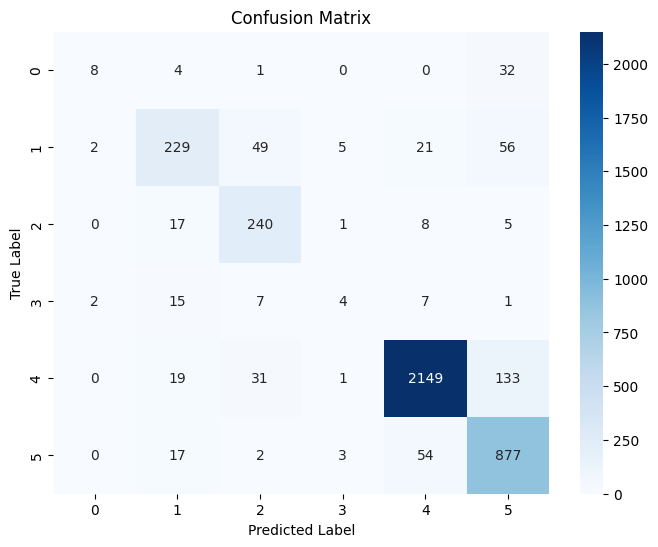

In [28]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [29]:
# Model-2 Baseline KNN

# XGBoost classifier
classifier = KNeighborsClassifier(n_neighbors=3)
feature_selection = SelectKBest(chi2)

# Pipeline combining preprocessing, feature selection, and classifier
knn1 = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])

knn1.fit(X_train,y_train)
# Make predictions on the validation set
y_pred = knn1.predict(X_val)

# Print classification report (decoded labels)
print(classification_report(y_val, y_pred))

                               precision    recall  f1-score   support

       Crimes against Persons       0.03      0.27      0.06        45
  Crimes against Public Order       0.23      0.40      0.29       362
Fraud and White-Collar Crimes       0.50      0.56      0.53       271
                 Other Crimes       0.00      0.00      0.00        36
              Property Crimes       0.89      0.77      0.83      2333
               Violent Crimes       0.54      0.39      0.45       953

                     accuracy                           0.62      4000
                    macro avg       0.37      0.40      0.36      4000
                 weighted avg       0.71      0.62      0.65      4000



In [30]:
# Model-2 KNN with hyperparameter tunning

# KNN classifier
classifier = KNeighborsClassifier(n_neighbors=3)
feature_selection = SelectKBest(chi2)

# Pipeline combining preprocessing, feature selection, and classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])

param_grid={
    'feature_selection__k': ['all'],
    'classifier__n_neighbors': [7],#[,3, 5],     # Typical values for K
    'classifier__weights': ['uniform'],# 'distance'], # Weighting of neighbors
    'classifier__p': [1],# 2]
    }

# Grid search with cross-validation
knn2 = GridSearchCV(pipeline, param_grid, cv=2, scoring='accuracy', verbose=3, error_score='raise')
knn2.fit(X_train, y_train)

# Get the best model and best score
best_model = knn2.best_estimator_
best_score = knn2.best_score_

print("Best Model:", best_model)
print("Best Score:", best_score)
print("Best Params:", knn2.best_params_)

# Make predictions on the validation set
y_pred = best_model.predict(X_val)

# Print classification report (decoded labels)
print(classification_report(y_val, y_pred))

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END classifier__n_neighbors=7, classifier__p=1, classifier__weights=uniform, feature_selection__k=all;, score=0.780 total time=   4.1s
[CV 2/2] END classifier__n_neighbors=7, classifier__p=1, classifier__weights=uniform, feature_selection__k=all;, score=0.785 total time=   3.9s
Best Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Time_Occurred', 'Area_ID', 'Reporting_District_no', 'Part 1-2',
       'Victim_Age', 'Premise_Code', 'Weapon_Used_Code'],
      dtype='object')),
                     

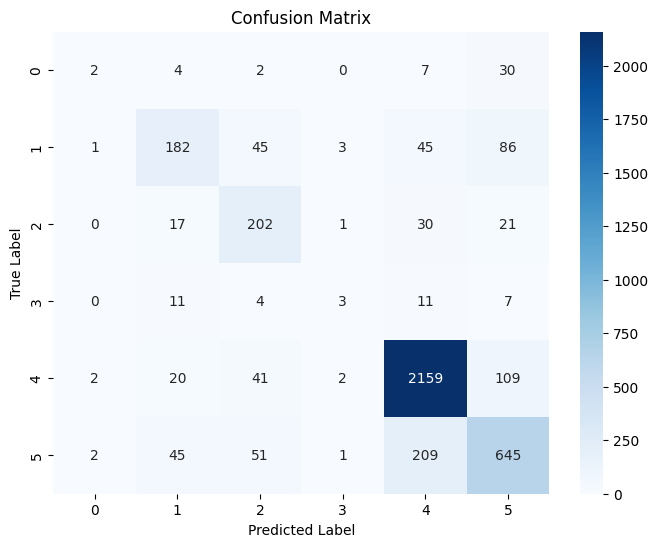

In [31]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [32]:
# Model-3 Baseline SVM

# SVM classifier
classifier = SVC()
feature_selection = SelectKBest(chi2)

# Pipeline combining preprocessing, feature selection, and classifier
svm1 = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])

svm1.fit(X_train,y_train)
# Make predictions on the validation set
y_pred = svm1.predict(X_val)

# Print classification report (decoded labels)
print(classification_report(y_val, y_pred))

                               precision    recall  f1-score   support

       Crimes against Persons       0.00      0.00      0.00        45
  Crimes against Public Order       0.86      0.27      0.41       362
Fraud and White-Collar Crimes       0.52      0.58      0.55       271
                 Other Crimes       0.00      0.00      0.00        36
              Property Crimes       0.80      0.89      0.84      2333
               Violent Crimes       0.56      0.58      0.57       953

                     accuracy                           0.72      4000
                    macro avg       0.46      0.39      0.39      4000
                 weighted avg       0.71      0.72      0.70      4000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
# Model-3 SVM with hyperparameter tunning

# SVM classifier
classifier = SVC()
feature_selection = SelectKBest(chi2)

# Pipeline combining preprocessing, feature selection, and classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])

param_grid = {
    'feature_selection__k': ['all'],
    'classifier__C': [100],
    'classifier__gamma': [0.01],
    'classifier__kernel': ['rbf']
}

# Grid search with cross-validation
svm2 = GridSearchCV(pipeline, param_grid, cv=2, scoring='accuracy', verbose=3, error_score='raise')
svm2.fit(X_train, y_train)

# Get the best model and best score
best_model = svm2.best_estimator_
best_score = svm2.best_score_

print("Best Model:", best_model)
print("Best Score:", best_score)
print("Best Params:", svm2.best_params_)

# Make predictions on the validation set
y_pred = best_model.predict(X_val)

# Print classification report (decoded labels)
print(classification_report(y_val, y_pred))

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END classifier__C=100, classifier__gamma=0.01, classifier__kernel=rbf, feature_selection__k=all;, score=0.859 total time=   8.4s
[CV 2/2] END classifier__C=100, classifier__gamma=0.01, classifier__kernel=rbf, feature_selection__k=all;, score=0.865 total time=   8.5s
Best Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Time_Occurred', 'Area_ID', 'Reporting_District_no', 'Part 1-2',
       'Victim_Age', 'Premise_Code', 'Weapon_Used_Code'],
      dtype='object')),
                                 

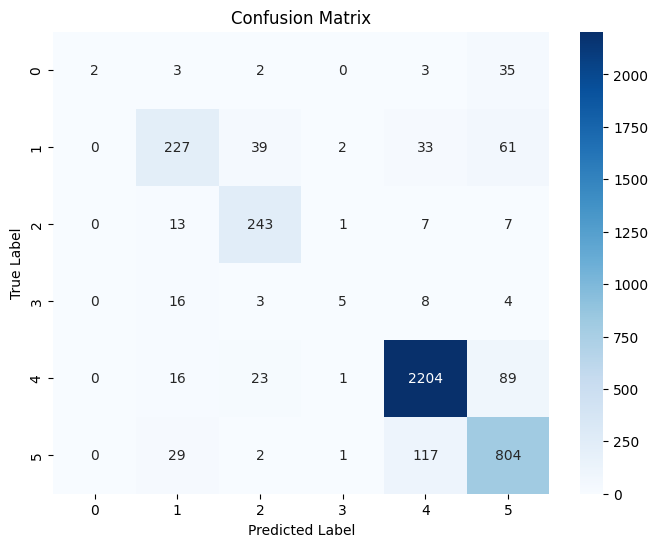

In [34]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [35]:
# Model-4 Baseline Random Forest Classifier

# Random Forest classifier
classifier = RandomForestClassifier()
feature_selection = SelectKBest(chi2)

# Pipeline combining preprocessing, feature selection, and classifier
rfc1 = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])

rfc1.fit(X_train,y_train)
# Make predictions on the validation set
y_pred = rfc1.predict(X_val)

# Print classification report (decoded labels)
print(classification_report(y_val, y_pred))

                               precision    recall  f1-score   support

       Crimes against Persons       0.00      0.00      0.00        45
  Crimes against Public Order       0.83      0.27      0.41       362
Fraud and White-Collar Crimes       0.52      0.56      0.54       271
                 Other Crimes       0.00      0.00      0.00        36
              Property Crimes       0.80      0.89      0.84      2333
               Violent Crimes       0.56      0.58      0.57       953

                     accuracy                           0.72      4000
                    macro avg       0.45      0.38      0.39      4000
                 weighted avg       0.71      0.72      0.70      4000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
# Model-4 Random Forest classifier with hyper parameter tunning
classifier = RandomForestClassifier()
feature_selection = SelectKBest(chi2)

# Pipeline combining preprocessing, feature selection, and classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])

# Parameter grid for GridSearchCV

param_grid = {
    'feature_selection__k': ['all'],
    'classifier__n_estimators': [120],
    'classifier__max_depth': [None],
    'classifier__min_samples_split': [3],
    'classifier__min_samples_leaf': [1],
    'classifier__bootstrap': [False],
    'classifier__criterion': ['gini'],
    'classifier__max_features': ['sqrt'],
    'classifier__class_weight': [None],
    'classifier__random_state': [42],
    'classifier__verbose': [0],
    'classifier__warm_start': [False],
    'classifier__min_weight_fraction_leaf': [0.0],  # Additional Random Forest parameters
    'classifier__ccp_alpha': [0.0]
}

# Grid search with cross-validation
rfc2 = GridSearchCV(pipeline, param_grid, cv=2, scoring='accuracy', verbose=3, error_score='raise')
rfc2.fit(X_train, y_train)

# Get the best model and best score
best_model = rfc2.best_estimator_
best_score = rfc2.best_score_

print("Best Model:", best_model)
print("Best Score:", best_score)
print("Best Params:", rfc2.best_params_)

# Make predictions on the validation set
y_pred = best_model.predict(X_val)

# Print classification report (decoded labels)
print(classification_report(y_val, y_pred))

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END classifier__bootstrap=False, classifier__ccp_alpha=0.0, classifier__class_weight=None, classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=3, classifier__min_weight_fraction_leaf=0.0, classifier__n_estimators=120, classifier__random_state=42, classifier__verbose=0, classifier__warm_start=False, feature_selection__k=all;, score=0.868 total time=  15.4s
[CV 2/2] END classifier__bootstrap=False, classifier__ccp_alpha=0.0, classifier__class_weight=None, classifier__criterion=gini, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=3, classifier__min_weight_fraction_leaf=0.0, classifier__n_estimators=120, classifier__random_state=42, classifier__verbose=0, classifier__warm_start=False, feature_selection__k=all;, score=0.870 total time=  15.7s
Best Model: P

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


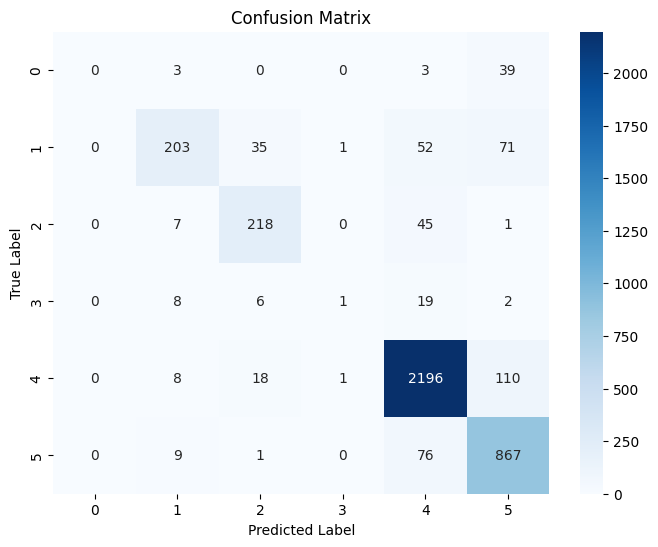

In [37]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [38]:
# Model-5 Baseline Gradient Boosting Classifier
classifier = GradientBoostingClassifier()
feature_selection = SelectKBest(chi2)

# Pipeline combining preprocessing, feature selection, and classifier
gbc1 = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])

gbc1.fit(X_train,y_train)
# Make predictions on the validation set
y_pred = gbc1.predict(X_val)

# Print classification report (decoded labels)
print(classification_report(y_val, y_pred))

                               precision    recall  f1-score   support

       Crimes against Persons       0.00      0.00      0.00        45
  Crimes against Public Order       0.86      0.27      0.41       362
Fraud and White-Collar Crimes       0.52      0.58      0.55       271
                 Other Crimes       0.00      0.00      0.00        36
              Property Crimes       0.80      0.89      0.84      2333
               Violent Crimes       0.56      0.58      0.57       953

                     accuracy                           0.72      4000
                    macro avg       0.46      0.39      0.39      4000
                 weighted avg       0.71      0.72      0.70      4000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
# Model-5 Gradient Boosting Classifier with hyper parameter tunning
classifier = GradientBoostingClassifier()
feature_selection = SelectKBest(chi2)

# Pipeline combining preprocessing, feature selection, and classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])

# Parameter grid for GridSearchCV

param_grid = {
    'feature_selection__k': ['all'],
    'classifier__n_estimators': [400],
    'classifier__learning_rate': [0.2],
    'classifier__max_depth': [9],
    'classifier__min_samples_split': [3],
    'classifier__min_samples_leaf': [2],
    'classifier__subsample': [1.0],
    # Add more GradientBoostingClassifier-specific hyperparameters here
    'classifier__max_features': ['sqrt'],
    'classifier__random_state': [42]
}

# Grid search with cross-validation
gbc2 = GridSearchCV(pipeline, param_grid, cv=2, scoring='accuracy', verbose=3, error_score='raise')
gbc2.fit(X_train, y_train)

# Get the best model and best score
best_model = gbc2.best_estimator_
best_score = gbc2.best_score_

print("Best Model:", best_model)
print("Best Score:", best_score)
print("Best Params:", gbc2.best_params_)

# Make predictions on the validation set
y_pred = best_model.predict(X_val)

# Print classification report (decoded labels)
print(classification_report(y_val, y_pred))

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END classifier__learning_rate=0.2, classifier__max_depth=9, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=3, classifier__n_estimators=400, classifier__random_state=42, classifier__subsample=1.0, feature_selection__k=all;, score=0.881 total time=  19.2s
[CV 2/2] END classifier__learning_rate=0.2, classifier__max_depth=9, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=3, classifier__n_estimators=400, classifier__random_state=42, classifier__subsample=1.0, feature_selection__k=all;, score=0.882 total time=  19.1s
Best Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                          

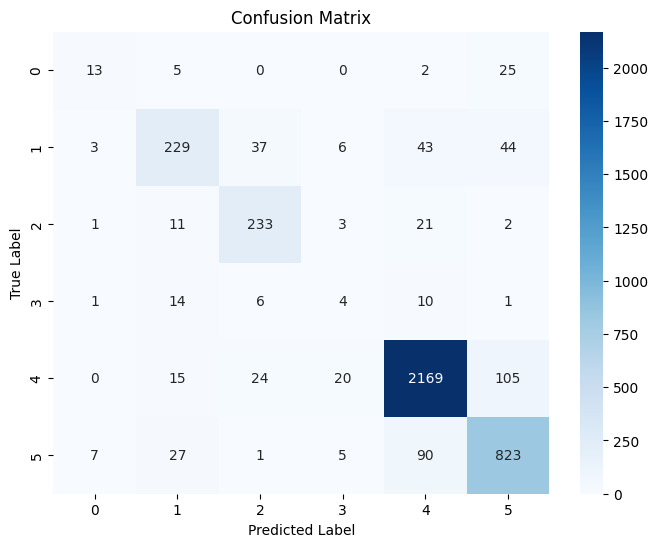

In [40]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [41]:
# Model-6 Multi Layer Perceptron Classifier
classifier = MLPClassifier(max_iter=500)
feature_selection = SelectKBest(chi2)

# Pipeline combining preprocessing, feature selection, and classifier
mlp1 = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])

mlp1.fit(X_train,y_train)
# Make predictions on the validation set
y_pred = mlp1.predict(X_val)

# Print classification report (decoded labels)
print(classification_report(y_val, y_pred))

                               precision    recall  f1-score   support

       Crimes against Persons       0.00      0.00      0.00        45
  Crimes against Public Order       0.86      0.27      0.41       362
Fraud and White-Collar Crimes       0.52      0.58      0.55       271
                 Other Crimes       0.00      0.00      0.00        36
              Property Crimes       0.80      0.89      0.84      2333
               Violent Crimes       0.56      0.58      0.57       953

                     accuracy                           0.72      4000
                    macro avg       0.46      0.39      0.39      4000
                 weighted avg       0.71      0.72      0.70      4000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
# Model-6 Multi Layer Perceptron Classifier
classifier = MLPClassifier(max_iter=500)  # Increase max_iter for complex datasets

# Pipeline combining preprocessing, feature selection, and classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])

# Parameter grid for GridSearchCV (adjusted for MLP)
param_grid = {
    'feature_selection__k': ['all'],
    'classifier__hidden_layer_sizes': [(100,)],#(50,), , (50, 50)],  # Number of neurons in hidden layers
    'classifier__activation': ['tanh'],# 'relu'],                 # Activation function
    'classifier__alpha': [0.001],# 0.0001],                       # L2 regularization parameter
    'classifier__learning_rate': ['constant'],# 'adaptive'],      # Learning rate schedule
}

# Grid search with cross-validation
mlp2 = GridSearchCV(pipeline, param_grid, cv=2, scoring='accuracy', verbose=3, error_score='raise')
mlp2.fit(X_train, y_train)

# Get the best model and best score
best_model = mlp2.best_estimator_
best_score = mlp2.best_score_

print("Best Model:", best_model)
print("Best Score:", best_score)
print("Best Params:", mlp2.best_params_)

# Make predictions on the validation set
y_pred = best_model.predict(X_val)

# Print classification report (decoded labels)
print(classification_report(y_val, y_pred))

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END classifier__activation=tanh, classifier__alpha=0.001, classifier__hidden_layer_sizes=(100,), classifier__learning_rate=constant, feature_selection__k=all;, score=0.838 total time= 2.0min
[CV 2/2] END classifier__activation=tanh, classifier__alpha=0.001, classifier__hidden_layer_sizes=(100,), classifier__learning_rate=constant, feature_selection__k=all;, score=0.838 total time= 2.1min
Best Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Time_Occurred', 'Area_ID', 'Reporting_District_no', 'Pa

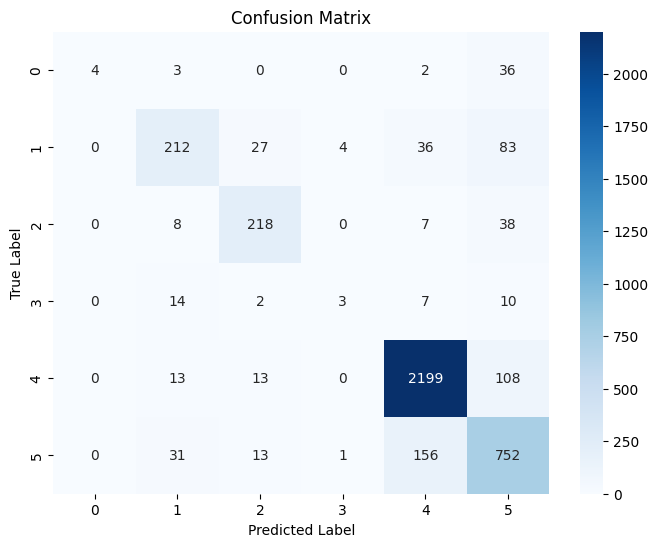

In [43]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [44]:
# Model-7 Baseline XGBoost classifier
classifier = XGBClassifier()
feature_selection = SelectKBest(chi2)

# Pipeline combining preprocessing, feature selection, and classifier
xgb1 = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])

encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoded = encoder.transform(y_train)
y_val_encoded = encoder.transform(y_val)
xgb1.fit(X_train,y_train_encoded)

# Make predictions on the validation set
y_pred = xgb1.predict(X_val)

# Print classification report (decoded labels)
print(classification_report(y_val_encoded, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.86      0.27      0.41       362
           2       0.52      0.58      0.55       271
           3       0.00      0.00      0.00        36
           4       0.80      0.89      0.84      2333
           5       0.56      0.58      0.57       953

    accuracy                           0.72      4000
   macro avg       0.46      0.39      0.39      4000
weighted avg       0.71      0.72      0.70      4000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
# Model-7 XGBoost with hyper parameter tunning
# XGBoost classifier
classifier = XGBClassifier(objective='reg:squarederror')
feature_selection = SelectKBest(chi2)

# Pipeline combining preprocessing, feature selection, and classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])

# Parameter grid for GridSearchCV

param_grid = {
    'feature_selection__k': ['all'],
    'classifier__max_depth': [5],
    'classifier__min_samples_split': [2],
    'classifier__min_samples_leaf': [1],
    'classifier__bootstrap': [False],
    'classifier__criterion': ['gini'],
    'classifier__max_features': ['sqrt'],
    'classifier__class_weight': ['balanced'],
    'classifier__random_state': [42],
    'classifier__verbose': [0],
    'classifier__warm_start': [True],
    'classifier__min_weight_fraction_leaf': [0.0],  # Additional XGBoost parameters
    'classifier__ccp_alpha': [0.0],
    'classifier__learning_rate': [0.1],
    'classifier__n_estimators': [450],
    'classifier__max_depth': [5],
    'classifier__min_child_weight': [1],
    'classifier__subsample': [1],
    'classifier__colsample_bytree': [0.8],
    'classifier__reg_alpha': [0.1],
    'classifier__gamma': [0.3],
}

encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoded = encoder.transform(y_train)
y_val_encoded = encoder.transform(y_val)

# Grid search with cross-validation
xgb2 = GridSearchCV(pipeline, param_grid, cv=2, scoring='accuracy', verbose=3, error_score='raise')
xgb2.fit(X_train, y_train_encoded)

# Get the best model and best score
best_model = xgb2.best_estimator_
best_score = xgb2.best_score_

print("Best Model:", best_model)
print("Best Score:", best_score)
print("Best Params:",xgb2.best_params_)

# Make predictions on test data
y_pred = best_model.predict(test)
y_pred_decoded = encoder.inverse_transform(y_pred)
#y_val_decoded = encoder.inverse_transform(y_pred)

pred = best_model.predict(X_val)
print(classification_report(y_val_encoded, pred))

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:22:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bootstrap", "ccp_alpha", "class_weight", "criterion", "max_features", "min_samples_leaf", "min_samples_split", "min_weight_fraction_leaf", "verbose", "warm_start" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/2] END classifier__bootstrap=False, classifier__ccp_alpha=0.0, classifier__class_weight=balanced, classifier__colsample_bytree=0.8, classifier__criterion=gini, classifier__gamma=0.3, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_child_weight=1, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__min_weight_fraction_leaf=0.0, classifier__n_estimators=450, classifier__random_state=42, classifier__reg_alpha=0.1, classifier__subsample=1, classifier__verbose=0, classifier__warm_start=True, feature_selection__k=all;, score=0.885 total time=  10.0s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:23:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bootstrap", "ccp_alpha", "class_weight", "criterion", "max_features", "min_samples_leaf", "min_samples_split", "min_weight_fraction_leaf", "verbose", "warm_start" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/2] END classifier__bootstrap=False, classifier__ccp_alpha=0.0, classifier__class_weight=balanced, classifier__colsample_bytree=0.8, classifier__criterion=gini, classifier__gamma=0.3, classifier__learning_rate=0.1, classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_child_weight=1, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__min_weight_fraction_leaf=0.0, classifier__n_estimators=450, classifier__random_state=42, classifier__reg_alpha=0.1, classifier__subsample=1, classifier__verbose=0, classifier__warm_start=True, feature_selection__k=all;, score=0.883 total time=  11.3s


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:23:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bootstrap", "ccp_alpha", "class_weight", "criterion", "max_features", "min_samples_leaf", "min_samples_split", "min_weight_fraction_leaf", "verbose", "warm_start" } are not used.

  warnings.warn(smsg, UserWarning)


Best Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Time_Occurred', 'Area_ID', 'Reporting_District_no', 'Part 1-2',
       'Victim_Age', 'Premise_Code', 'Weapon_Used_Code'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),...
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_

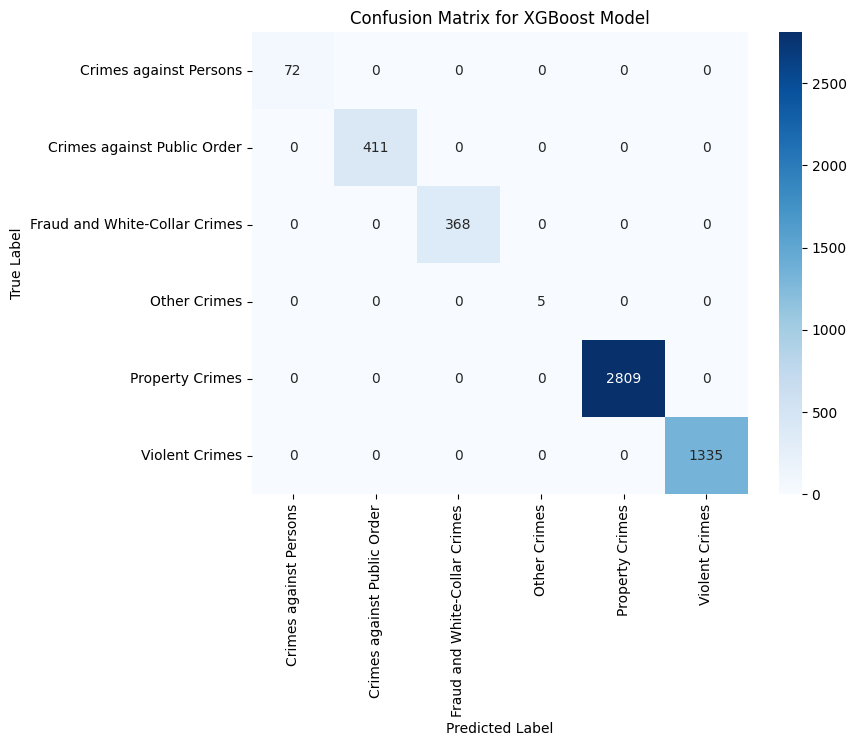

In [46]:
y_pred_encoded = best_model.predict(X_val)
y_val_decoded = encoder.inverse_transform(y_pred)
# Get the confusion matrix
cm = confusion_matrix(y_val_decoded, y_pred_decoded)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for XGBoost Model')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


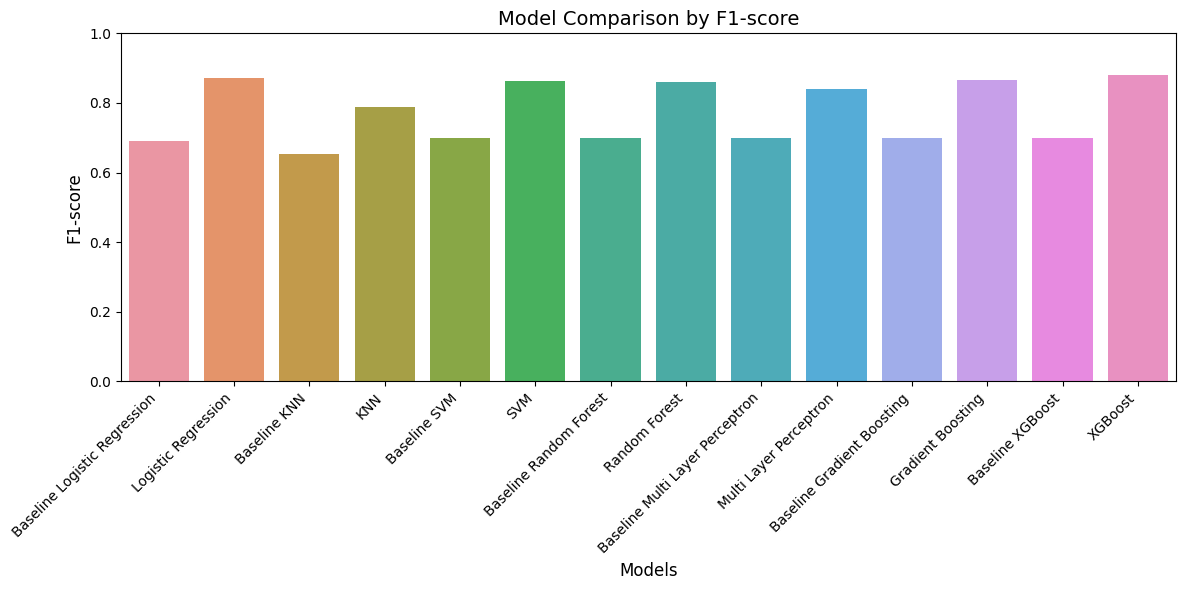

In [47]:
# Models to evaluate
models = {
    "Baseline Logistic Regression": lr1,
    "Logistic Regression": lr2,
    "Baseline KNN": knn1,
    "KNN": knn2,
    "Baseline SVM": svm1,
    "SVM": svm2,
    "Baseline Random Forest": rfc1,
    "Random Forest": rfc2,
    "Baseline Multi Layer Perceptron": mlp1,
    "Multi Layer Perceptron": mlp2,
    "Baseline Gradient Boosting": gbc1,
    "Gradient Boosting": gbc2,
    "Baseline XGBoost": xgb1,
    "XGBoost": xgb2  # Adding XGBoost to the list of models
}

# List to store F1-scores for each model
f1_scores = []

for model_name, model in models.items():
    if model_name == "XGBoost" or model_name == "Baseline XGBoost":
        # Fit and encode labels
        encoder = LabelEncoder()
        encoder.fit(y_train)
        y_train_encoded = encoder.transform(y_train)
        y_val_encoded = encoder.transform(y_val)

        # Make predictions
        y_pred_encoded = model.predict(X_val)

        # Calculate F1-score using encoded values
        f1 = f1_score(y_val_encoded, y_pred_encoded, average='weighted')
    else:
        # Make predictions
        y_pred = model.predict(X_val)

        # Ensure y_pred is of the same type as y_val
        if y_val.dtype != y_pred.dtype:
            y_pred = y_pred.astype(y_val.dtype)

        # Calculate F1-score
        f1 = f1_score(y_val, y_pred, average='weighted')

    # Append the F1-score to the list
    f1_scores.append(f1)

plt.figure(figsize=(12, 6))  # Increase width to accommodate rotated labels
sns.barplot(x=list(models.keys()), y=f1_scores)
plt.xlabel('Models', fontsize=12)  # Adjust font size for x-axis labels
plt.ylabel('F1-score', fontsize=12)
plt.title('Model Comparison by F1-score', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.ylim(0, 1)  # Assuming F1-score is between 0 and 1
plt.tight_layout()  # Ensure labels fit within figure area
plt.show()

In [48]:
# Make predictions on test data
y_pred = best_model.predict(test)

y_pred_decoded = encoder.inverse_transform(y_pred)

# Create submission DataFrame
submission = pd.DataFrame({"ID": range(1, len(y_pred) + 1), "Crime_Category": y_pred_decoded})

# Save submission to CSV file
submission.to_csv('submission.csv', index=False)